# Retrieval Information Evaluation

Goal : Evaluate Retrieval part of the RAG pipeline.

- use appropriate non Eval LLM metrics like Recall from Information Retrieval (IR) (LLM based metrics will be used later on)
- Allow hyperparameter tuning (chunck size, embedding model, number of retrieved documents, use a RERANKER or not, add metadata to the chuncks)
- Create clear visuals
- Focus on Reproductibility with a small dataset. 

**IMPORTANT** : If you want to get access to the sample dataset for the embedding models Retrieval Information Evaluation, you need to load the relevant documents from this S3 bucket folder: **s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/**

### Extract data sample

From **data_complete.csv** (raw data) OR **insee_documents.csv** (Extracted metadata and paragraphs)

In [ ]:
#python insee_data_processing.py
import pandas as pd

data = pd.read_csv("data_complete.csv", low_memory=False)
data_sample = data.sample(1000)
data_sample.head()

from utils import extract_paragraphs
data_sample = extract_paragraphs(data_sample)

In [4]:
from tqdm import tqdm
from langchain.docstore.document import Document as LangchainDocument

# pd.DataFrame.from_dict(data_sample)
ds = pd.read_csv("insee_documents.csv", low_memory=False)

,Unnamed: 0,id_origin,paragraphs,url_source,titles_para,categories,dateDiffusion,themes,collections,libelleAffichageGeo,intertitres,authors,subtitle
0,0,1280888,"Entre 2008 et 2010, dans un contexte de crise,...",https://www.insee.fr/fr/statistiques/1280888,Innover pour résister à la crise ou se dévelop...,Publications grand public,2012-10-23T22:00:00Z,"['Mondialisation, compétitivité et innovation']",Insee Première,France,"Entre 2008 et 2010, la moitié des sociétés de ...","['Anthony Bouvier', 'division Enquêtes thémati...",NaN
1,1,1280890,"En 2011, le déficit public s’établit à 103,1mi...",https://www.insee.fr/fr/statistiques/1280890,Les comptes des administrations publiques en 2011,Publications grand public,2012-05-15T05:30:00Z,['Finances publiques'],Insee Première,France,"En 2011, le déficit public atteint 5,2 % du PI...","['Denis Boisnault', 'département des Comptes n...",NaN
2,2,1280892,L’année agricole 2012 est marquée par l’abonda...,https://www.insee.fr/fr/statistiques/1280892,Les comptes prévisionnels de l’agriculture pou...,Publications grand public,2012-12-12T16:00:00Z,['Agriculture'],Insee Première,France,Le prix des céréales augmente fortement Le pri...,"['Claire Lesdos-Cauhapé', 'division Industrie ...",Les récoltes de céréales augmentent et leurs p...
3,3,1280894,"En 2009, en France, 1,6 million de personnes, ...",https://www.insee.fr/fr/statistiques/1280894,"La vie en communauté: 1,6 million de personnes...",Publications grand public,2013-02-05T23:00:00Z,"['Évolution et structure de la population', 'L...",Insee Première,France,"En 2009, un habitant sur 40 vit dans une commu...","['David Pirou', 'Nadine Poullain et Sandrine R...",NaN
4,4,1280896,"En 2009, 25,7 millions de personnes occupent u...",https://www.insee.fr/fr/statistiques/1280896,Une photographie du marché du travail en 2009,Publications grand public,2011-01-13T23:00:00Z,"['Emploi – Population active', 'Chômage']",Insee Première,France,"En un an, le taux d'emploi a chuté de 1,2 poin...",['Anne Mansuy et Cédric Nouël de la Buzonnière...,Résultats de l’enquête Emploi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34562,34562,8059425,"En février 2024, le prix du pétrole en euros a...",https://www.insee.fr/fr/information/8059425,"En février 2024, le prix du pétrole accélère, ...",Publications pour expert,2024-03-22T11:00:00Z,"['Commerce extérieur', 'Énergie', 'Économie gé...",Informations rapides,France,"Matières premières importées (ensemble, hors é...",[],Prix des énergies et des matières premières im...
34563,34563,8059442,"Au quatrième trimestre 2023, l’indice des loye...",https://www.insee.fr/fr/information/8059442,"Au quatrième trimestre 2023, l’indice des loye...",Publications pour expert,2024-03-29T11:00:00Z,"['Caractéristiques du commerce', 'Conjoncture']",Informations rapides,France,Indice des loyers commerciaux Indice des loyer...,[],Indice des loyers commerciaux (ILC) - quatrièm...
34564,34564,8059444,"Entre fin septembre 2023 et fin décembre 2023,...",https://www.insee.fr/fr/information/8059444,"Au quatrième trimestre 2023, l’emploi salarié ...",Publications pour expert,2024-03-26T11:00:00Z,"['Chômage', 'Conjoncture']",Informations rapides,France,L’emploi est quasi stable pour un grand nombre...,[],Emploi et taux de chômage localisés (par régio...
34565,34565,8059452,L’indice du coût de la construction (ICC) s’ét...,https://www.insee.fr/fr/information/8059452,"Au quatrième trimestre 2023, l’indice du coût ...",Publications pour expert,2024-03-29T11:00:00Z,"['Construction', 'Conjoncture']",Informations rapides,France,Indice du coût de la construction Indice du co...,[],Indice du coût de la construction (ICC) - quat...


In [52]:
langchain_docs = [LangchainDocument(
            page_content= doc["paragraphs"],
             metadata={"source": doc["url_source"], 
             "title": doc["titles_para"],
             "insee_id": doc["id_origin"], 
             "categories" : doc["categories"],
             "date_diffusion" : doc["dateDiffusion"], 
             "themes" : doc["themes"],
             "collections" : doc["collections"], 
             "libelleAffichageGeo" : doc["libelleAffichageGeo"], 
             "intertitres" : doc["intertitres"],
             "authors" : doc["authors"],
             "subtitle" : doc["subtitle"]
             }) for _, doc in tqdm(ds.iterrows())]

560it [00:00, 5598.10it/s]

34567it [00:02, 12321.21it/s]


In [53]:
len(langchain_docs)

34567

### Get the top N documents with largest contexts

In [59]:
from typing import List 

def get_top_n_documents_with_largest_content(documents : List[LangchainDocument], n=1000):
    # Create a list of tuples (content_size, document)
    document_sizes = [(len(doc.page_content.split()), doc) for doc in documents]

    # Sort the list by content size in descending order
    sorted_documents = sorted(document_sizes, key=lambda x: x[0], reverse=True)

    # Get the top N documents
    top_n_documents = [doc for (_ , doc) in sorted_documents[:n]]

    return top_n_documents

sample_langchain_docs = get_top_n_documents_with_largest_content(langchain_docs, n=100)

In [60]:
import numpy as np 

def stats(documents : List[LangchainDocument], type = "categories"):
    if not documents:
        return None, None, None

    res = {}
    for doc in documents :
        if doc.metadata[type] in res.keys():
            res[doc.metadata[type]].append(len(doc.page_content.split()))
        else:
            res[doc.metadata[type]] = [len(doc.page_content.split())]

    for k in res.keys():
        lengths = res[k]
        n = len(lengths)
        max_length = max(lengths)
        min_length = min(lengths)
        avg_length = sum(lengths) / len(lengths)
        res[k] = (n , max_length, np.round(avg_length,2) , min_length)

    return res

stats(sample_langchain_docs)

{'Services': (3, 20281, 17138.33, 15235),
 'Publications grand public': (51, 15990, 6858.88, 5010),
 'Courrier des statistiques': (42, 7082, 5790.71, 4962),
 'Publications pour expert': (4, 5637, 5395.25, 5157)}

In [63]:
def store_langchain_document(documents : List[LangchainDocument]):
    data = []
    
    for document in documents:
        # Create a dictionary for each document
        doc_data = {
            'content': document.page_content,
        }
        # Add metadata fields
        doc_data.update(document.metadata)

        data.append(doc_data)

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    return df
        
df = store_langchain_document(sample_langchain_docs)
# Optionally, save the DataFrame to a CSV file
output_csv_path = "insee_documents_sample_ref_retrieval_evaluation.csv"
df.to_csv(output_csv_path, index=False)

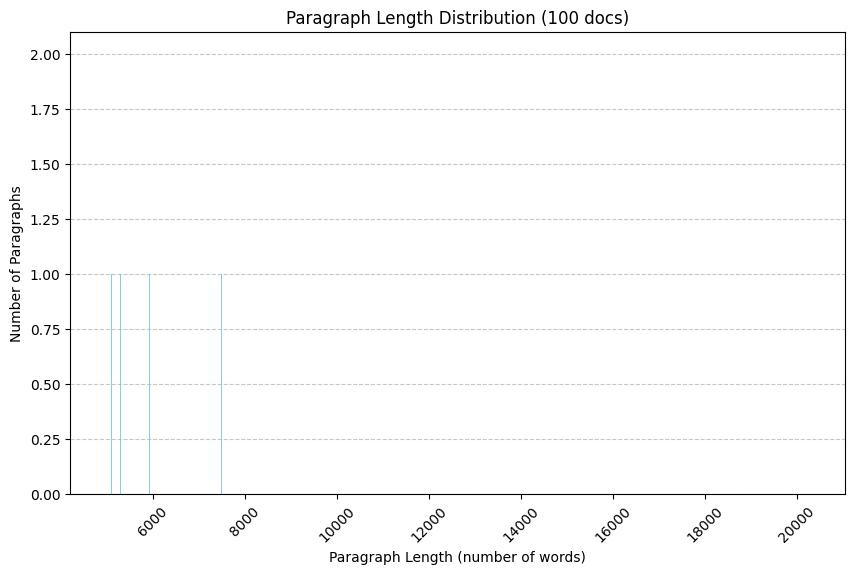

In [61]:
from collections import Counter
import matplotlib.pyplot as plt 

counters_para = Counter()

for doc in sample_langchain_docs:
    counters_para[len(doc.page_content.split())] +=1

lengths_sorted = sorted(counters_para.items())
lengths , counts = zip(*lengths_sorted)
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts, color='skyblue')
plt.xlabel('Paragraph Length (number of words)')
plt.ylabel('Number of Paragraphs')
plt.title( f'Paragraph Length Distribution ({len(sample_langchain_docs)} docs)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Generate Questions

In [78]:
# load reference dataset :

path_data = "/home/onyxia/work/insee_documents_sample_ref_retrieval_evaluation.csv"
data = pd.read_csv(path_data)

raw_ref_database  = []
for i, row in tqdm(data.iterrows()):
    doc = row.to_dict()
    page_content = doc["content"]
    if 'content' in doc:
        del doc["content"]
    metadata = doc
    raw_ref_database.append(LangchainDocument(page_content=page_content, metadata = metadata))

0it [00:00, ?it/s]

In [77]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer 
from langchain.docstore.document import Document as LangchainDocument
from transformers import AutoTokenizer

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str]) -> List[LangchainDocument]:

    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []

    for doc in tqdm(knowledge_base):
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [81]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer

REF_EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
MARKDOWN_SEPARATORS = ["\n\n","\n","."," ", ""]

print(f"----------Loading Embedding model {REF_EMBEDDING_MODEL_NAME}------------")

embedding_model = HuggingFaceEmbeddings( #load sentence transformers 
    model_name=REF_EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
    show_progress = False
)

print("---------Chunking LangChain documents-----------")

embedder_max_token_length  = SentenceTransformer(REF_EMBEDDING_MODEL_NAME).max_seq_length
print(f"max sequence of token for {REF_EMBEDDING_MODEL_NAME} : {embedder_max_token_length}")

docs_processed_sample = split_documents(knowledge_base = raw_ref_database, 
                                        chunk_size = embedder_max_token_length,
                                        tokenizer_name = REF_EMBEDDING_MODEL_NAME)

print("----------Building Chroma DB------------")
collection_name = "insee_sample_" + str(REF_EMBEDDING_MODEL_NAME.split("/")[-1]) 
db_chroma = Chroma.from_documents(collection_name=collection_name, persist_directory="./chroma_db" , documents = docs_processed_sample, embedding=embedding_model)

----------Loading Embedding model sentence-transformers/all-MiniLM-L6-v2------------


/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------Chunking LangChain documents-----------
max sequence of token for sentence-transformers/all-MiniLM-L6-v2 : 256


  0%|          | 0/100 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


----------Building Chroma DB------------


In [84]:
import torch 
from transformers import pipeline
import numpy as np 

def remove_extra_spaces(text):
    # Split the text by whitespaces and join them with a single whitespace
    return ' '.join(text.split())

def extract_question(text):
    return text.split("?")[0] + "?"

Q_generation_prompt = """
<|user|>
Ta tâche consiste à écrire une question factuelle en te basant sur un contexte donné.
Ta question factuelle doit pouvoir être répondue par une information factuelle spécifique et concise tirée du contexte.
Ta question factuelle doit être formulée dans le même style que les questions que les utilisateurs pourraient poser dans un moteur de recherche.
Cela signifie que ta question factuelle NE DOIT PAS mentionner des phrases comme "selon le passage" ou "le contexte".
La question doit avoir pour sujet une thématiques d'un institut de statistique public. 
Tu DOIS respecter faire apparaitre "Question factuelle : " avant ta réponse. 
<|user|>
<|assistant|>
Voici maintenant le contexte.

Contexte : {context}

Question factuelle : (ta question factuelle)
<|assistant|>
"""

def generate_test_question(vector_database : Chroma, pipeline : pipeline, nb_documents = 50, batch_size = 5, generation_args = None):
    """
    Generate Question based on a given vector_database (based on the smallest "max_length_token").  
    """
    test_data = {"question" : [] , "content" : [], "source" : []}

    #sample indices
    indices = np.random.choice(len(vector_database.get()["ids"]), nb_documents)
    
    for x in indices:
        doc = vector_database.get()["metadatas"][x]
        source = doc["source"]
        content = vector_database.get()["documents"][x]

        test_data["content"].append(content)
        test_data["source"].append(source) 

    torch.cuda.empty_cache()
    print(f"Generating {nb_documents} Questions ...")
    #generate final prompts 
    batch_prompts = [Q_generation_prompt.format(context=ctx) for ctx in test_data["content"]]
    #add batch size params
    if "batch_size" not in generation_args.keys() : 
        generation_args["batch_size"] = batch_size
    
    with torch.no_grad():
        generated_out = pipeline(batch_prompts, **generation_args)
        
    for out in generated_out:
        output_Q = out[0]["generated_text"]
        question = extract_question(remove_extra_spaces(output_Q.split("Question factuelle : ")[-1])) 
        test_data["question"].append(question)

    return test_data
   

In [83]:
from transformers import BitsAndBytesConfig,  AutoModelForCausalLM, AutoTokenizer,  AutoConfig
import torch

model_name = "microsoft/Phi-3-mini-128k-instruct" 

#load LLM config 
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)

#load quantization config 
quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype="float16",
        bnb_4bit_use_double_quant=False,
)

tokenizer = AutoTokenizer.from_pretrained(model_name) 
model = AutoModelForCausalLM.from_pretrained(
            model_name,
            config=config,
            quantization_config=quantization_config,
            device_map="cuda", 
            torch_dtype="auto", 
            trust_remote_code=True,
        )
model

config.json:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3SuScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipeline("text-generation", model = model, tokenizer=tokenizer)

generation_args = {
    "max_new_tokens": 300,
    "return_full_text": False,
    "do_sample": False,
}
test_data  = generate_test_question(vector_database = db_chroma, pipeline = pipe, nb_documents = 100, batch_size = 10, generation_args = generation_args)
q_and_s_df = pd.DataFrame(test_data)
q_and_s_df.to_csv(f"Q&S_ref_retrieval_evaluation_{model_name.split("/")[-1]}.csv")

Generating 100 Questions ...


### Evaluates Embedding models on Retrieval Task

embedding model to test : 
- sentence-transformers/all-MiniLM-L6-v2 (multi)
- manu/sentence_croissant_alpha_v0.4
- OrdalieTech/Solon-embeddings-large-0.1
- sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
- intfloat/multilingual-e5-large

### Evaluate Retrieval 

In [138]:
from langchain_core.vectorstores import VectorStore
from tqdm import tqdm 
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, multilabel_confusion_matrix

def recall(retrieved, relevant):
    intersection = set(retrieved) & set(relevant)
    return len(intersection) / len(relevant)

def precision(retrieved, relevant):
    intersection = set(retrieved) & set(relevant)
    return len(intersection) / len(retrieved) if len(retrieved) > 0 else 0

def compute_hit_rate(predictions, labels):
    """ 
    Hit rate metric is equivalent to the accuracy 
    """
    correct_predictions = sum(1 for pred, label in zip(predictions, labels) if pred == label)
    total_predictions = len(predictions)
    hit_rate = correct_predictions / total_predictions
    return hit_rate

def test_retriever(knowledge_index: VectorStore, eval_data : pd.DataFrame, embedding_model : HuggingFaceEmbeddings):
    #recall at K : look at the k first document retrieved 
    """ 
    compute some metrics :
    recall @ 1 , 2, 3 5, 10 , 15
    mrr 
    f1 score 
    """
    results = {"question" : [], "source": [], "pred": [], "recall_at_1" : [], "recall_at_2": [],"recall_at_3": [],"recall_at_5" : [],"recall_at_10" : [], "recall_at_15" : [], "mrr_score": [] }

    print("pre-computing query embeddings")
    queries = list(eval_data["question"])
    embeddings_queries = embedding_model.embed_documents(queries)
    
    for i, row in tqdm(eval_data.iterrows()):
    
        q = row["question"]
        source = row["source"]

        results["question"].append(q)
        results["source"].append(source)
        
        embedded_query = embeddings_queries[i]
        retrieved_docs = knowledge_index.similarity_search_by_vector(embedding = embedded_query, k = 15)
        retrieved_sources = [doc.metadata["source"] for doc in retrieved_docs]
        
        #compute recall at 
        results["recall_at_1"].append(recall(retrieved_sources[:1], [source]))
        results["recall_at_2"].append(recall(retrieved_sources[:2], [source]))
        results["recall_at_3"].append(recall(retrieved_sources[:3], [source]))
        results["recall_at_5"].append(recall(retrieved_sources[:5], [source]))
        results["recall_at_10"].append(recall(retrieved_sources[:10], [source]))
        results["recall_at_15"].append(recall(retrieved_sources[:15], [source]))

        #compute Mean Reciprocal Rank (Order Aware Metrics)
        if source not in retrieved_sources:
            mrr_score = 1/ np.inf
        else : 
            rank_q = retrieved_sources.index(source)
            mrr_score = 1 / (rank_q + 1)

        results["mrr_score"].append(mrr_score)

        results["pred"].append(retrieved_sources[0]) #will be compare to source using precision and recall and average precision 
        
    results_agg = {
        "recall_at_1" :  np.mean(results["recall_at_1"]),
        "recall_at_2" : np.mean(results["recall_at_2"]), 
        "recall_at_3" :  np.mean(results["recall_at_3"]),
        "recall_at_5" :  np.mean(results["recall_at_5"]),
        "recall_at_10" : np.mean(results["recall_at_10"]),
        "recall_at_15" : np.mean(results["recall_at_15"]),
        "precision_score" : precision_score(y_true = results["source"], y_pred=results["pred"], average="micro"),
        "f1_score": f1_score(y_true =results["source"], y_pred= results["pred"], average="micro"),
        "mrr" : np.mean(results["mrr_score"]),
        "hit_rate" : compute_hit_rate(predictions = results["pred"], labels= results["source"])
    }
    return results, results_agg


In [136]:
embedding_model_test = ["sentence-transformers/all-MiniLM-L6-v2","manu/sentence_croissant_alpha_v0.4", "OrdalieTech/Solon-embeddings-large-0.1", "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", "intfloat/multilingual-e5-large"]

In [149]:
# Define the benchmark file path
save_benchmark = "./benchmark_embedding_models.csv"

# Function to read the existing benchmark CSV or create a new DataFrame if it doesn't exist
def load_or_create_benchmark(file_path):
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        return None

# Load the existing benchmark data or create a new DataFrame
df_benchmark = load_or_create_benchmark(save_benchmark)

# Iterate over each embedding model to test
for EMBEDDING_MODEL_NAME in embedding_model_test:

    if df_benchmark is not None and "model_name" in df_benchmark.columns:
        if EMBEDDING_MODEL_NAME in df_benchmark["model_name"].values:
            print(f"{EMBEDDING_MODEL_NAME} already evaluated. Skipping...")
            continue 

    # Load the embedding model to get the max token length
    embedder = SentenceTransformer(EMBEDDING_MODEL_NAME)
    embedder_max_token_length = embedder.max_seq_length

    print("--------- Chunking LangChain documents")
    print(f"Max sequence length for {EMBEDDING_MODEL_NAME}: {embedder_max_token_length}")
    documents = split_documents(
        knowledge_base = raw_ref_database,
        chunk_size= embedder_max_token_length,
        tokenizer_name=EMBEDDING_MODEL_NAME
    )

    print(f"---------- Loading Embedding model {EMBEDDING_MODEL_NAME}")
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        multi_process=True,
        model_kwargs={"device": "cuda"},
        encode_kwargs={"normalize_embeddings": True},  # Set True for cosine similarity
        show_progress=False
    )

    print("---------- Building Chroma DB")
    collection_name = "insee_sample_" + EMBEDDING_MODEL_NAME.split("/")[-1]
    db_chroma = Chroma.from_documents(
        collection_name=collection_name,
        persist_directory="./chroma_db",
        documents = documents,
        embedding=embedding_model
    )

    print(f"---------- Evaluating Retrieval Performances for {EMBEDDING_MODEL_NAME}")
    eval_data = pd.read_csv("/home/onyxia/work/Q&S_ref_retrieval_evaluation_Phi-3-mini-128k-instruct.csv")
    results, results_agg = test_retriever(db_chroma, eval_data, embedding_model)

    results_agg["model_name"] = EMBEDDING_MODEL_NAME

    print("---------- Storing Performance Results")
    if df_benchmark is None:
        df_benchmark = pd.DataFrame(columns=list(results_agg.keys())) 

    df_benchmark = pd.concat([df_benchmark, pd.DataFrame([results_agg])], ignore_index=True)
    df_benchmark.to_csv(save_benchmark, index=False)
    print(f"Results stored in {save_benchmark}")

print("Evaluation complete.")

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--------- Chunking LangChain documents
Max sequence length for sentence-transformers/all-MiniLM-L6-v2: 256


100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


---------- Loading Embedding model sentence-transformers/all-MiniLM-L6-v2
---------- Building Chroma DB
---------- Evaluating Retrieval Performances for sentence-transformers/all-MiniLM-L6-v2
pre-computing query embeddings


100it [00:00, 265.31it/s]
/tmp/ipykernel_7289/1756318280.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_benchmark = pd.concat([df_benchmark, pd.DataFrame([results_agg])], ignore_index=True)


---------- Storing Performance Results
Results stored in ./benchmark_embedding_models.csv


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/185k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

--------- Chunking LangChain documents
Max sequence length for manu/sentence_croissant_alpha_v0.4: 1024


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


---------- Loading Embedding model manu/sentence_croissant_alpha_v0.4
---------- Building Chroma DB
---------- Evaluating Retrieval Performances for manu/sentence_croissant_alpha_v0.4
pre-computing query embeddings


100it [00:00, 142.43it/s]


---------- Storing Performance Results
Results stored in ./benchmark_embedding_models.csv


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

--------- Chunking LangChain documents
Max sequence length for OrdalieTech/Solon-embeddings-large-0.1: 512


100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


---------- Loading Embedding model OrdalieTech/Solon-embeddings-large-0.1
---------- Building Chroma DB
---------- Evaluating Retrieval Performances for OrdalieTech/Solon-embeddings-large-0.1
pre-computing query embeddings


100it [00:00, 291.36it/s]


---------- Storing Performance Results
Results stored in ./benchmark_embedding_models.csv


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

--------- Chunking LangChain documents
Max sequence length for sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2: 128


100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


---------- Loading Embedding model sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
---------- Building Chroma DB
---------- Evaluating Retrieval Performances for sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
pre-computing query embeddings


100it [00:00, 357.75it/s]


---------- Storing Performance Results
Results stored in ./benchmark_embedding_models.csv


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

--------- Chunking LangChain documents
Max sequence length for intfloat/multilingual-e5-large: 512


100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


---------- Loading Embedding model intfloat/multilingual-e5-large
---------- Building Chroma DB
---------- Evaluating Retrieval Performances for intfloat/multilingual-e5-large
pre-computing query embeddings


100it [00:00, 243.41it/s]

---------- Storing Performance Results
Results stored in ./benchmark_embedding_models.csv
Evaluation complete.


In [150]:
df_benchmark = load_or_create_benchmark(save_benchmark)
df_benchmark

,recall_at_1,recall_at_2,recall_at_3,recall_at_5,recall_at_10,recall_at_15,precision_score,f1_score,mrr,hit_rate,model_name
0,0.58,0.58,0.58,0.58,0.63,0.69,0.58,0.58,0.591758,0.58,sentence-transformers/all-MiniLM-L6-v2
1,0.63,0.71,0.75,0.80,0.86,0.89,0.63,0.63,0.705531,0.63,manu/sentence_croissant_alpha_v0.4
2,0.85,0.89,0.91,0.93,0.94,0.95,0.85,0.85,0.884048,0.85,OrdalieTech/Solon-embeddings-large-0.1
3,0.63,0.70,0.76,0.81,0.87,0.89,0.63,0.63,0.706472,0.63,sentence-transformers/paraphrase-multilingual-...
4,0.82,0.89,0.90,0.92,0.93,0.94,0.82,0.82,0.865667,0.82,intfloat/multilingual-e5-large
